In [9]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import display

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
    precision_score,
    recall_score,
)

from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve

CSV_PATH = "data.csv"          # Kaggle breast cancer wisconsin (diagnostic)
TARGET_COL = "diagnosis"       # 'M' or 'B'
POS_LABEL = "M"                # malignant = 1

RANDOM_STATE = 42
TEST_SIZE = 0.20
CV_SPLITS = 5

TARGET_RECALL = 0.98           # choosing threshold to hit this recall on OOF
MIN_AUTO_CASES = 20
ALPHA = 0.05                   # 95% bound


def header(title: str) -> None:
    print("\n" + title)
    print("-" * len(title))


def show_table(df: pd.DataFrame, title: str) -> None:
    header(title)
    display(df)


def safe_probs(arr: np.ndarray) -> np.ndarray:
    p = np.asarray(arr, dtype=np.float64)
    p = np.nan_to_num(p, nan=0.0, posinf=1.0, neginf=0.0)
    return np.clip(p, 0.0, 1.0)


def uncertainty(p: np.ndarray) -> np.ndarray:
    p = safe_probs(p)
    return np.minimum(p, 1.0 - p)  # [0, 0.5]


def confusion_metrics(y_true: np.ndarray, p_pos: np.ndarray, decision_th: float) -> dict:
    p_pos = safe_probs(p_pos)
    y_hat = (p_pos >= decision_th).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_true, y_hat).ravel()

    auroc = roc_auc_score(y_true, p_pos)
    auprc = average_precision_score(y_true, p_pos)
    prec = precision_score(y_true, y_hat, zero_division=0)
    rec = recall_score(y_true, y_hat, zero_division=0)
    spec = tn / (tn + fp) if (tn + fp) else float("nan")
    fnr = fn / (fn + tp) if (fn + tp) else float("nan")

    return {
        "decision_th": float(decision_th),
        "auroc": float(auroc),
        "auprc": float(auprc),
        "precision": float(prec),
        "recall": float(rec),
        "specificity": float(spec),
        "fnr": float(fnr),
        "tn": int(tn), "fp": int(fp), "fn": int(fn), "tp": int(tp),
    }


def pick_threshold_for_recall(y_true: np.ndarray, p_pos: np.ndarray, target_recall: float) -> float:
    p_pos = safe_probs(p_pos)
    thresholds = np.linspace(0.0, 1.0, 1001)

    chosen = None
    for th in thresholds:
        rec = recall_score(y_true, (p_pos >= th).astype(int), zero_division=0)
        if rec >= target_recall:
            chosen = th  # highest threshold achieving target recall

    if chosen is not None:
        return float(chosen)

    # fallback
    best_th, best_rec, best_prec = 0.5, -1.0, -1.0
    for th in thresholds:
        y_hat = (p_pos >= th).astype(int)
        rec = recall_score(y_true, y_hat, zero_division=0)
        prec = precision_score(y_true, y_hat, zero_division=0)
        if (rec > best_rec) or (rec == best_rec and prec > best_prec):
            best_th, best_rec, best_prec = th, rec, prec
    return float(best_th)


def clopper_pearson_upper(k: int, n: int, alpha: float = 0.05) -> float:
    if n <= 0:
        return float("nan")
    try:
        from scipy.stats import beta  # type: ignore
        if k >= n:
            return 1.0
        return float(beta.ppf(1 - alpha / 2, k + 1, n - k))
    except Exception:
        # Wilson fallback
        z = 1.96
        p = k / n
        denom = 1 + (z*z)/n
        center = (p + (z*z)/(2*n)) / denom
        margin = (z/denom) * np.sqrt((p*(1-p)/n) + (z*z)/(4*n*n))
        return float(min(1.0, center + margin))


def eval_policy(y_true: np.ndarray, p_pos: np.ndarray, u: np.ndarray, u_th: float, decision_th: float) -> dict:
    p_pos = safe_probs(p_pos)
    u = np.asarray(u, dtype=np.float64)

    auto = u <= u_th
    coverage = float(auto.mean())

    if auto.any():
        pred_auto = (p_pos[auto] >= decision_th).astype(int)
        auto_acc = float((pred_auto == y_true[auto]).mean())
        fn_auto = int(((y_true[auto] == 1) & (pred_auto == 0)).sum())
    else:
        auto_acc = float("nan")
        fn_auto = 0

    pos_total = int((y_true == 1).sum())
    miss = fn_auto / pos_total if pos_total else float("nan")
    miss_ub = clopper_pearson_upper(fn_auto, pos_total, alpha=ALPHA) if pos_total else float("nan")

    return {
        "u_th": float(u_th),
        "coverage": float(coverage),
        "auto_acc": float(auto_acc),
        "fn_auto": int(fn_auto),
        "miss": float(miss),
        "miss_ub": float(miss_ub),
        "auto_n": int(auto.sum()),
        "referred_n": int((~auto).sum()),
    }


In [10]:
# Data ingestion, preprocessing and split.
header("LOAD DATA")

df = pd.read_csv(CSV_PATH)

drop_cols = [c for c in ["Unnamed: 32", "id"] if c in df.columns]# Kaggle file sometimes includes an all null column and an ID column

df = df.drop(columns=drop_cols, errors="ignore")

if TARGET_COL not in df.columns:
    raise ValueError(f"Missing target '{TARGET_COL}'. Found: {list(df.columns)}")

y = (df[TARGET_COL].astype(str).str.upper() == POS_LABEL).astype(int)
X = df.drop(columns=[TARGET_COL]).copy()

# Forcing all features to numeric because non-parsable values become NaN for imputation later.
for c in X.columns:
    X[c] = pd.to_numeric(X[c], errors="coerce")

print(f"Loaded shape: {df.shape}")
print(f"Positive rate (M=1): {y.mean():.3f} | positives={int(y.sum())} / {len(y)}")

preview = pd.concat([y.rename("target"), X.iloc[:, :8]], axis=1).head(3)
show_table(preview, "Preview (first 3 rows, first 8 features)")

header("TRAIN/TEST SPLIT")

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

print(f"Sizes: trainval={len(X_trainval)}, test={len(X_test)} | positives: trainval={int(y_trainval.sum())}, test={int(y_test.sum())}")

header("MISSINGNESS (TRAINVAL ONLY)")

missing_rate = X_trainval.isna().mean().sort_values(ascending=False)
missing_tbl = (
    missing_rate.rename("missing_frac")
    .reset_index()
    .rename(columns={"index": "feature"})
    .head(15)
)

show_table(missing_tbl, "Top missingness features (trainval)")

num_cols = X_trainval.columns.tolist()



LOAD DATA
---------
Loaded shape: (569, 31)
Positive rate (M=1): 0.373 | positives=212 / 569

Preview (first 3 rows, first 8 features)
----------------------------------------


,target,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean
0,1,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710
1,1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017
2,1,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790



TRAIN/TEST SPLIT
----------------
Sizes: trainval=455, test=114 | positives: trainval=170, test=42

MISSINGNESS (TRAINVAL ONLY)
---------------------------

Top missingness features (trainval)
-----------------------------------


,feature,missing_frac
0,radius_mean,0.0
1,texture_mean,0.0
2,symmetry_worst,0.0
3,concave points_worst,0.0
4,concavity_worst,0.0
5,compactness_worst,0.0
6,smoothness_worst,0.0
7,area_worst,0.0
8,perimeter_worst,0.0
9,texture_worst,0.0


In [11]:
# Preprocessing numeric features (impute and scale) and training a regularized logistic regression baseline.
preprocess = ColumnTransformer(
    transformers=[
        ("num",
         Pipeline(steps=[
             ("imputer", SimpleImputer(strategy="median")),
             ("scaler", StandardScaler()),
         ]),
         num_cols)
    ],
    remainder="drop",
)

clf = Pipeline(
    steps=[
        ("prep", preprocess),
        ("lr", LogisticRegression(
            solver="liblinear",
            C=0.2,
            max_iter=3000,
            random_state=RANDOM_STATE,
        )),
    ]
)


In [12]:
# Picking a decision threshold from out of fold predictions
header("OOF CV (TRAINVAL): THRESHOLD SELECTION")

skf = StratifiedKFold(n_splits=CV_SPLITS, shuffle=True, random_state=RANDOM_STATE)

oof_p = np.zeros(len(X_trainval), dtype=np.float64)
oof_y = y_trainval.to_numpy().astype(int)

for fold, (tr_idx, va_idx) in enumerate(skf.split(X_trainval, y_trainval), start=1):
    X_tr = X_trainval.iloc[tr_idx]
    y_tr = y_trainval.iloc[tr_idx]
    X_va = X_trainval.iloc[va_idx]

    clf.fit(X_tr, y_tr)
    oof_p[va_idx] = clf.predict_proba(X_va)[:, 1]

oof_p = safe_probs(oof_p)
oof_u = uncertainty(oof_p)

decision_th = pick_threshold_for_recall(oof_y, oof_p, target_recall=TARGET_RECALL)
print(f"Chosen decision threshold from OOF (target recall={TARGET_RECALL:.2f}): {decision_th:.3f}")

oof_base = confusion_metrics(oof_y, oof_p, decision_th)
print(
    f"OOF baseline at chosen threshold:\n"
    f"AUROC={oof_base['auroc']:.3f} | AUPRC={oof_base['auprc']:.3f} | "
    f"Precision={oof_base['precision']:.3f} | Recall={oof_base['recall']:.3f} | "
    f"Specificity={oof_base['specificity']:.3f} | FNR={oof_base['fnr']:.3f} | "
    f"Confusion [tn fp; fn tp]=[{oof_base['tn']} {oof_base['fp']}; {oof_base['fn']} {oof_base['tp']}]"
)



OOF CV (TRAINVAL): THRESHOLD SELECTION
--------------------------------------
Chosen decision threshold from OOF (target recall=0.98): 0.279
OOF baseline at chosen threshold:
AUROC=0.995 | AUPRC=0.994 | Precision=0.933 | Recall=0.982 | Specificity=0.958 | FNR=0.018 | Confusion [tn fp; fn tp]=[273 12; 3 167]


In [13]:
# Checking different referral thresholds to balance coverage against missed positives.
header("OOF POLICY SWEEP")

levels = np.linspace(0.05, 0.95, 40)
u_thresholds = np.unique(np.quantile(oof_u, levels))

rows = []
for uth in u_thresholds:
    rows.append(eval_policy(oof_y, oof_p, oof_u, float(uth), decision_th))

val_sweep = pd.DataFrame(rows).sort_values("u_th").reset_index(drop=True)
show_table(val_sweep.head(12), "OOF policy sweep (first 12 rows)")

header("SELECTED POLICIES (FROM OOF)")

cand = val_sweep[val_sweep["auto_n"] >= MIN_AUTO_CASES].copy()

high_cov = cand.sort_values(["coverage", "auto_acc"], ascending=[False, False]).iloc[0]
conservative = cand.sort_values(["miss_ub", "coverage"], ascending=[True, False]).iloc[0]

mid_band = cand[(cand["coverage"] >= 0.90) & (cand["coverage"] <= 0.95)]
if len(mid_band) > 0:
    balanced = mid_band.sort_values(["miss_ub", "auto_acc"], ascending=[True, False]).iloc[0]
else:
    balanced = cand.iloc[len(cand)//2]

selected = pd.DataFrame([
    {"policy": "High coverage", **high_cov.to_dict()},
    {"policy": "Balanced", **balanced.to_dict()},
    {"policy": "Conservative", **conservative.to_dict()},
])

show_table(
    selected[["policy","u_th","coverage","auto_acc","miss","miss_ub","auto_n","referred_n"]],
    "Selected policies (OOF)"
)



OOF POLICY SWEEP
----------------

OOF policy sweep (first 12 rows)
--------------------------------


,u_th,coverage,auto_acc,fn_auto,miss,miss_ub,auto_n,referred_n
0,0.000013,0.050549,1.0,0,0.0,0.021466,23,432
1,0.000055,0.074725,1.0,0,0.0,0.021466,34,421
2,0.000103,0.096703,1.0,0,0.0,0.021466,44,411
3,0.000176,0.120879,1.0,0,0.0,0.021466,55,400
4,0.000267,0.142857,1.0,0,0.0,0.021466,65,390
5,0.000416,0.167033,1.0,0,0.0,0.021466,76,379
6,0.000605,0.189011,1.0,0,0.0,0.021466,86,369
7,0.000827,0.213187,1.0,0,0.0,0.021466,97,358
8,0.001031,0.235165,1.0,0,0.0,0.021466,107,348
9,0.001431,0.257143,1.0,0,0.0,0.021466,117,338



SELECTED POLICIES (FROM OOF)
----------------------------

Selected policies (OOF)
-----------------------


,policy,u_th,coverage,auto_acc,miss,miss_ub,auto_n,referred_n
0,High coverage,0.294628,0.949451,0.988426,0.017647,0.050704,432.0,23.0
1,Balanced,0.224942,0.925275,0.992874,0.017647,0.050704,421.0,34.0
2,Conservative,0.012727,0.558242,1.000000,0.000000,0.021466,254.0,201.0



FINAL FIT (TRAINVAL)
--------------------

TOP COEFFICIENTS (LOGISTIC REGRESSION)
--------------------------------------

Top 10 coefficients (by absolute value)
---------------------------------------


,feature,coef,abs_coef
0,texture_worst,0.772298,0.772298
1,radius_se,0.653652,0.653652
2,radius_worst,0.610333,0.610333
3,area_worst,0.590953,0.590953
4,symmetry_worst,0.590299,0.590299
5,concave points_mean,0.559750,0.559750
6,perimeter_worst,0.545051,0.545051
7,area_se,0.510446,0.510446
8,concave points_worst,0.502319,0.502319
9,texture_mean,0.483583,0.483583


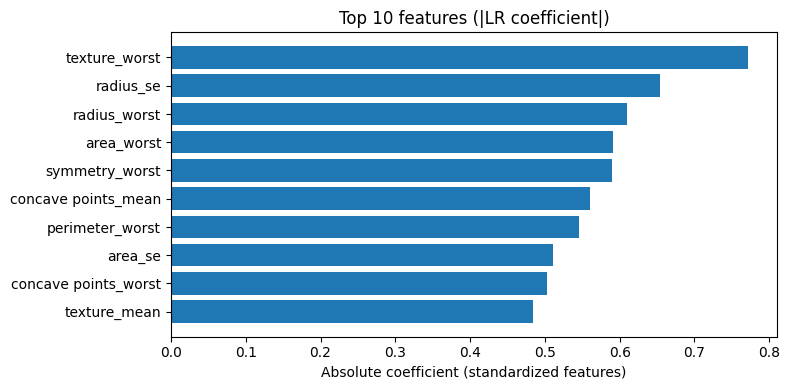

In [14]:
# Fitting the final model on all train/validation data and checking which features drive the predictions.
header("FINAL FIT (TRAINVAL)")
clf.fit(X_trainval, y_trainval)

header("TOP COEFFICIENTS (LOGISTIC REGRESSION)")
coefs = clf.named_steps["lr"].coef_[0]

coef_tbl = (
    pd.DataFrame({"feature": num_cols, "coef": coefs, "abs_coef": np.abs(coefs)})
    .sort_values("abs_coef", ascending=False)
    .head(10)
    .reset_index(drop=True)
)

show_table(coef_tbl, "Top 10 coefficients (by absolute value)")

plt.figure(figsize=(8, 4))
plt.barh(coef_tbl["feature"], coef_tbl["abs_coef"])
plt.xlabel("Absolute coefficient (standardized features)")
plt.title("Top 10 features (|LR coefficient|)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()



TEST BASELINE (NO REFERRAL)
---------------------------
decision_th=0.279 | AUROC=0.998 | AUPRC=0.997 | Precision=0.911 | Recall=0.976 | Specificity=0.944 | FNR=0.024 | Confusion [tn fp; fn tp]=[68 4; 1 41]

PROBABILITY QUALITY (TEST): BRIER + CALIBRATION CURVE
-----------------------------------------------------
TEST Brier score: 0.0198


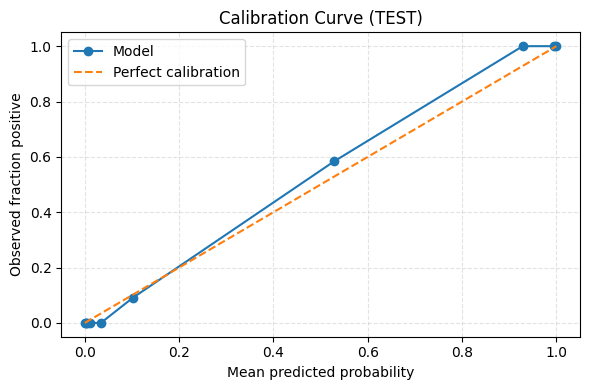

In [15]:
# Checking how the model performs on the test set with no referrals, then looking at the probability calibration 
header("TEST BASELINE (NO REFERRAL)")

p_test = safe_probs(clf.predict_proba(X_test)[:, 1])
u_test = uncertainty(p_test)
y_test_np = y_test.to_numpy().astype(int)

test_base = confusion_metrics(y_test_np, p_test, decision_th)

print(
    f"decision_th={test_base['decision_th']:.3f} | AUROC={test_base['auroc']:.3f} | AUPRC={test_base['auprc']:.3f} | "
    f"Precision={test_base['precision']:.3f} | Recall={test_base['recall']:.3f} | "
    f"Specificity={test_base['specificity']:.3f} | FNR={test_base['fnr']:.3f} | "
    f"Confusion [tn fp; fn tp]=[{test_base['tn']} {test_base['fp']}; {test_base['fn']} {test_base['tp']}]"
)

header("PROBABILITY QUALITY (TEST): BRIER + CALIBRATION CURVE")

brier = brier_score_loss(y_test_np, p_test)
print(f"TEST Brier score: {brier:.4f}")

frac_pos, mean_pred = calibration_curve(
    y_test_np,
    p_test,
    n_bins=10,
    strategy="quantile"
)

plt.figure(figsize=(6, 4))
plt.plot(mean_pred, frac_pos, marker="o", label="Model")
plt.plot([0, 1], [0, 1], linestyle="--", label="Perfect calibration")
plt.xlabel("Mean predicted probability")
plt.ylabel("Observed fraction positive")
plt.title("Calibration Curve (TEST)")
plt.grid(True, linestyle="--", alpha=0.35)
plt.legend()
plt.tight_layout()
plt.show()



TEST: REFERRAL POLICY RESULTS
-----------------------------

Test referral policy results
----------------------------


,policy,u_th,coverage,auto_acc,miss,miss_ub,auto_n,referred_n,fn_auto
0,High coverage,0.294628,0.929825,0.981132,0.02381,0.125659,106,8,1
1,Balanced,0.224942,0.912281,0.990385,0.02381,0.125659,104,10,1
2,Conservative,0.012727,0.552632,1.000000,0.00000,0.084084,63,51,0



PLOTS (TEST)
------------


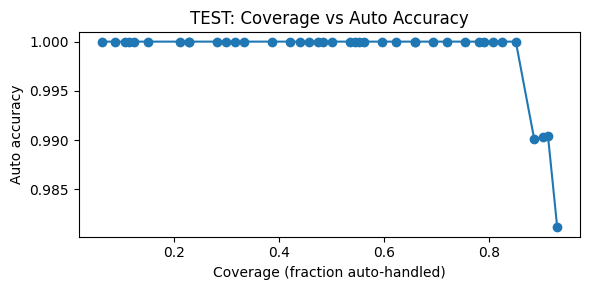

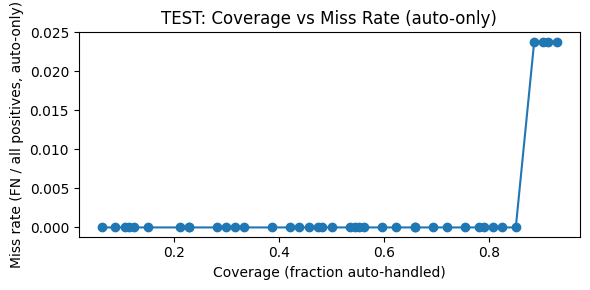

In [16]:
# Applying the chosen referral policies to the held out test set and visualizing the coverage vs safety trade off across thresholds.
header("TEST: REFERRAL POLICY RESULTS")

test_rows = []
for _, row in selected.iterrows():
    r = eval_policy(y_test_np, p_test, u_test, float(row["u_th"]), decision_th)
    test_rows.append({"policy": row["policy"], **r})

test_policy_df = pd.DataFrame(test_rows)

show_table(
    test_policy_df[["policy","u_th","coverage","auto_acc","miss","miss_ub","auto_n","referred_n","fn_auto"]],
    "Test referral policy results"
)
header("PLOTS (TEST)")

test_sweep_rows = []
for uth in u_thresholds:
    r = eval_policy(y_test_np, p_test, u_test, float(uth), decision_th)
    test_sweep_rows.append({"coverage": r["coverage"], "auto_acc": r["auto_acc"], "miss": r["miss"]})

test_sweep = pd.DataFrame(test_sweep_rows).sort_values("coverage")

plt.figure(figsize=(6, 3))
plt.plot(test_sweep["coverage"], test_sweep["auto_acc"], marker="o")
plt.xlabel("Coverage (fraction auto-handled)")
plt.ylabel("Auto accuracy")
plt.title("TEST: Coverage vs Auto Accuracy")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 3))
plt.plot(test_sweep["coverage"], test_sweep["miss"], marker="o")
plt.xlabel("Coverage (fraction auto-handled)")
plt.ylabel("Miss rate (FN / all positives, auto-only)")
plt.title("TEST: Coverage vs Miss Rate (auto-only)")
plt.tight_layout()
plt.show()


# takeaways
- I built an end-to-end classification pipeline on the Wisconsin Breast Cancer dataset using Logistic Regression, with careful train/test separation and cross-validation.
- Instead of using the default 0.5 cutoff, I selected a decision threshold from out-of-fold predictions to prioritize high recall.
- I added a simple “defer to a human” mechanism. When the model is uncertain, it flags the case for review rather than forcing a prediction. 
- I evaluated both accuracy-style metrics (AUROC/AUPRC) and probability quality (Brier score and calibration curve) to check that predicted probabilities are meaningful.

# Limitations 
- The uncertainty signal is derived directly from the model’s predicted probability, which is a useful heuristic but not a full measure of model uncertainty.
- Results are based on one dataset and one train/test split so performance and calibration could change under different splits or on truly external data.
